# 0. IMPORTS

In [1]:
import pandas as pd 
import plotly.express as px 
import ipywidgets as widgets
import seaborn as sns
from geopy.geocoders import Nominatim
from ipywidgets      import fixed, interact, interact_manual, interactive
from matplotlib      import gridspec
from matplotlib      import pyplot as plt
from matplotlib      import ticker

pd.set_option('display.float_format', '{:,.2f}'.format)

# 1. UPLOADING FILES

In [2]:
path = r'C:\Users\andre\repos\python-zero-ao-ds\datasets\kc_house_data.csv'

df_raw = pd.read_csv(path)
df_raw.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,"221,900.00",3,1.00,1180,5650,1.00,0,0,...,7,1180,0,1955,0,98178,47.51,-122.26,1340,5650
1,6414100192,20141209T000000,"538,000.00",3,2.25,2570,7242,2.00,0,0,...,7,2170,400,1951,1991,98125,47.72,-122.32,1690,7639
2,5631500400,20150225T000000,"180,000.00",2,1.00,770,10000,1.00,0,0,...,6,770,0,1933,0,98028,47.74,-122.23,2720,8062
3,2487200875,20141209T000000,"604,000.00",4,3.00,1960,5000,1.00,0,0,...,7,1050,910,1965,0,98136,47.52,-122.39,1360,5000
4,1954400510,20150218T000000,"510,000.00",3,2.00,1680,8080,1.00,0,0,...,8,1680,0,1987,0,98074,47.62,-122.05,1800,7503


In [3]:
df_raw.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

# 2. ANSWERING CEO's QUESTIONS

### 1. Qual a quantidade de imóveis por nível?
    - Nível 0: Imóveis com preço entre 0 até 321.950
    - Nível 1: Imóveis com preço entre 321.950 até 450.000
    - Nível 2: Imóveis com preço entre 450.000 até 645.000
    - Nível 3: Imóveis com preço acima de 645.000

In [4]:
df1 = df_raw.copy()

In [5]:
for i in range(0, len(df1)):
    
    if (df1.loc[i, 'price'] >= 0) & (df1.loc[i, 'price'] <= 321950):
        df1.loc[i, 'level'] = 'level_0'
        
    elif (df1.loc[i, 'price'] >= 321950) & (df1.loc[i, 'price'] <= 450000):
        df1.loc[i, 'level'] = 'level_1'
        
    elif (df1.loc[i, 'price'] >= 450000) & (df1.loc[i, 'price'] <= 645000):
        df1.loc[i, 'level'] = 'level_2'
    
    else:
        df1.loc[i, 'level'] = 'level_3'

df1['level'].value_counts()

level_1    5460
level_0    5404
level_2    5376
level_3    5373
Name: level, dtype: int64

### 2. Adicione as seguintes informações ao imóvel:
    - Nome da rua
    - Número do imóvel
    - Nome do bairro
    - Nome da cidade
    - Nome do estado

In [6]:
# Check if lat/long variables are in the correct type
df1[['lat', 'long']].dtypes

lat     float64
long    float64
dtype: object

In [7]:
# Create sample of dataframe only to apply the framework (in the complete dataframe would take too long)
df2 = df1.sample(100, random_state=42).reset_index()

df2.head()

,index,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,level
0,735,2591820310,20141006T000000,"365,000.00",4,2.25,2070,8893,2.00,0,...,2070,0,1986,0,98058,47.44,-122.16,2390,7700,level_1
1,2830,7974200820,20140821T000000,"865,000.00",5,3.00,2900,6730,1.00,0,...,1830,1070,1977,0,98115,47.68,-122.28,2370,6283,level_3
2,4106,7701450110,20140815T000000,"1,038,000.00",4,2.50,3770,10893,2.00,0,...,3770,0,1997,0,98006,47.56,-122.13,3710,9685,level_3
3,16218,9522300010,20150331T000000,"1,490,000.00",3,3.50,4560,14608,2.00,0,...,4560,0,1990,0,98034,47.70,-122.23,4050,14226,level_3
4,19964,9510861140,20140714T000000,"711,000.00",3,2.50,2550,5376,2.00,0,...,2550,0,2004,0,98052,47.66,-122.08,2250,4050,level_3


In [8]:
# Initialize Nominatim API

geolocator = Nominatim(user_agent='geoapiExercises')

# create empty rows that will receive address info

df2['road'] = 'NA'
df2['house_number'] = 'NA'
df2['neighbourhood'] = 'NA'
df2['city'] = 'NA' 
df2['state'] = 'NA'

for i in range(0, len(df2)):
    
    response = geolocator.reverse(str(df2['lat'][i]) + ',' + str(df2['long'][i]))
    
    if 'road' in response.raw['address']:
        df2.loc[i, 'road'] = response.raw['address']['road']
        
    if 'house_number' in response.raw['address']:
        df2.loc[i, 'house_number'] = response.raw['address']['house_number']
        
    if 'neighbourhood' in response.raw['address']:
        df2.loc[i, 'neighbourhood'] = response.raw['address']['neighbourhood']
        
    if 'city' in response.raw['address']:
        df2.loc[i, 'city'] = response.raw['address']['city']
        
    if 'state' in response.raw['address']:
        df2.loc[i, 'state'] = response.raw['address']['state']

In [9]:
df2.sample(10)

,index,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,lat,long,sqft_living15,sqft_lot15,level,road,house_number,neighbourhood,city,state
91,11937,5112800060,20140606T000000,"455,000.00",4,1.75,2050,94525,1.00,0,...,47.45,-122.08,2270,47480,level_2,Southeast 170th Street,19225,NA,Renton,Washington
55,10815,2325069032,20140731T000000,"875,000.00",5,4.25,4720,18741,2.00,0,...,47.63,-122.01,3880,37328,level_3,Northeast 27th Place,24424,NA,Sammamish,Washington
18,18835,1138000450,20141016T000000,"355,000.00",4,1.00,1440,7215,1.50,0,...,47.71,-122.21,1150,7215,level_1,Northeast 126th Place,9765,NA,NA,Washington
93,2084,5317100570,20141215T000000,"1,250,000.00",3,2.50,2070,4944,2.00,0,...,47.63,-122.28,3300,6179,level_3,McGilvra Boulevard East,541,NA,Seattle,Washington
37,5512,1822069109,20140910T000000,"485,000.00",3,2.50,2540,51836,1.00,0,...,47.39,-122.09,1650,51836,level_2,Southeast 237th Place,19009,NA,Kent,Washington
28,16118,9432900250,20150309T000000,"329,990.00",4,2.75,2420,8438,2.00,0,...,47.21,-122.01,2270,8770,level_1,Lois Lane,3233,NA,Enumclaw,Washington
12,15468,4202400078,20150128T000000,"175,000.00",2,1.00,1410,7000,1.00,0,...,47.49,-122.22,1540,6000,level_0,Stevens Avenue Northwest,520,NA,Renton,Washington
25,13958,8651540040,20140718T000000,"549,000.00",3,2.25,1920,10961,2.00,0,...,47.64,-122.06,2000,10706,level_2,211th Place Northeast,3698,NA,Sammamish,Washington
40,11275,226059065,20140903T000000,"514,000.00",3,2.25,2260,54014,1.00,0,...,47.77,-122.13,2140,44431,level_2,Northeast 191st Street,15651,NA,Woodinville,Washington
95,3559,2919201095,20150327T000000,"540,000.00",3,1.00,1270,3840,1.50,0,...,47.69,-122.36,1270,4175,level_2,North 84th Street,123,NA,Seattle,Washington


### 3. Adicione o nível do imóvel no mapa como uma cor (que cada nível signifique uma cor).

In [16]:
properties = df1[['id', 'lat', 'long', 'price', 'level']].copy()

fig = px.scatter_mapbox(df1,
                        lat='lat',
                        lon='long',
                        color='level',
                        size='price', 
                        zoom=10,
                        color_continuous_scale=px.colors.diverging)

fig.update_layout(mapbox_style='stamen-terrain', title = 'Available Properties in Seattle-WA')
fig.update_layout(margin={'r':0, 't':0, 'l':0, 'b':0}, height=600)

fig.show()

### 4. Adicione opções de filtros para que eu possa fazer minhas próprias análises:

In [27]:
df1['is_waterfront'] = df1['waterfront'].apply(lambda x: 'yes' if x == 1 else 'no')

style = {'description_widht': 'initial'}

# Price button
price_limit = widgets.IntSlider(value=75000,
                                min=75000,
                                max=7700000,
                                step=1,
                                description='Maximum Price',
                                disable=False,
                                style=style)

# Waterfront button
waterfront_bar = widgets.Dropdown(options=df1['is_waterfront'].unique().tolist(),
                                  value='yes',
                                  description='waterview',
                                  disable=False)

In [ ]:
# def update_map(df, limit, waterfront):

#     con1 = df1['price'] <= limit
#     con2 = df1['waterfront'] == waterfront
    
#     properties = 

In [16]:
def update_map(df, waterfront, limit):

    properties = df[(df['price'] <= limit) & (df['is_waterfront'] == waterfront)][['id', 'lat', 'long', 'price', 'level']]
                    
    fig = px.scatter_mapbox(properties,
                        lat = 'lat',
                        lon = 'long',
                        color = 'level',
                        size = 'price',
                        size_max=15,
                        color_continuous_scale=px.colors.cyclical.IceFire,
                        zoom = 10)

    fig.update_layout(mapbox_style='open-street-map')
    fig.update_layout(height=600, margin={'r':0, 't':0, 'l':0, 'b':0})
    fig.show()

In [17]:
widgets.interactive(update_map, df=fixed(df), waterfront=waterfront_bar, limit=price_limit)

interactive(children=(Dropdown(description='Water View', index=1, options=('no', 'yes'), value='yes'), IntSlid…

### 5. Interatividade com o dashboard

In [18]:
# Prepare data

df['year'] = pd.to_datetime(df['date']).dt.strftime('%Y')
df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')
df['year_week'] = pd.to_datetime(df['date']).dt.strftime('%Y-%U')

# Widgets to control data
date_limit = widgets.SelectionSlider(
                options=df['date'].sort_values().drop_duplicates().to_list(),
                value='2014-12-01',
                description='Availability',
                continuous_update=False,
                orientation='horizontal',
                readout=True)

def update_map(df, limit):
    
    # Filter date
    data = df[df['date'] >= limit]
    
    fig = plt.figure(figsize=(24, 12))
    specs = gridspec.GridSpec(nrows=2, ncols=2, figure=fig)
    
    ax1 = fig.add_subplot(specs[0,:]) # First row
    ax2 = fig.add_subplot(specs[1,0]) # Second row - First colum
    ax3 = fig.add_subplot(specs[1,1]) # Second row - Second column
    
    by_year = data[['price', 'year']].groupby('year').sum().reset_index()
    ax1.bar(by_year['year'], by_year['price'])
    ax1.set_title('Sum of Prices by Year')
    
    by_day = data[['price', 'date']].groupby('date').mean().reset_index()
    ax2.plot(by_day['date'], by_day['price'])
    ax2.set_title('Average Price by Day')
    
    by_week = data[['price', 'year_week']].groupby('year_week').mean().reset_index()
    ax3.bar(by_week['year_week'], by_week['price'])
    ax3.set_title('Average Price by Week')
    
    plt.xticks(rotation=60)

In [19]:
widgets.interactive(update_map, df=fixed(df), limit=date_limit)

interactive(children=(SelectionSlider(continuous_update=False, description='Availability', index=212, options=…

# 3. NEW CEO's QUESTIONS

### 1. Qual a média do preço de compra dos imóveis por nível?
    1. Nível 0: Preço de 0 até 321950
    2. Nível 1: Preço de 321950 até 450000
    3. Nível 2: Preço de 450000 até 645000
    4. Nível 3: Preço acima de 645000

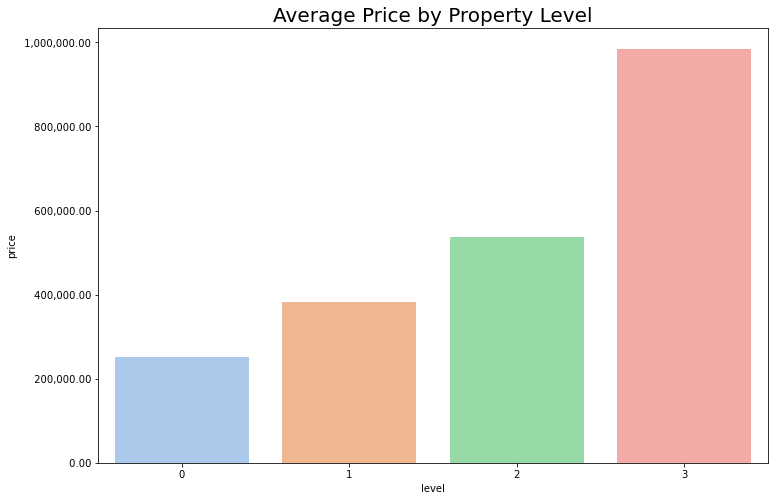

In [20]:
# Group data and takes mean price by property level
price_by_level = df[['level', 'price']].groupby('level').mean().reset_index()

# Sets figure size
plt.figure(figsize=(12, 8))

# Plots grapgh and sets title
ax = sns.barplot(x='level', y='price', data=price_by_level, palette='pastel')
ax.set_title('Average Price by Property Level', fontsize=20)

# Adjust y axis numbers formatter
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x: ,.2f}'))

### 2. Qual a média do tamanho da sala de estar dos imóveis por “size”?
    1. Size 0 → Tamanho entre 0 até 1427 sqft
    2. Size 1 → Tamanho entre 1427 até 1910 sqft
    3. Size 2 → Tamanho entre 1910 até 2550 sqft
    4. Size 3 → Tamanho acima de 2550 sqft

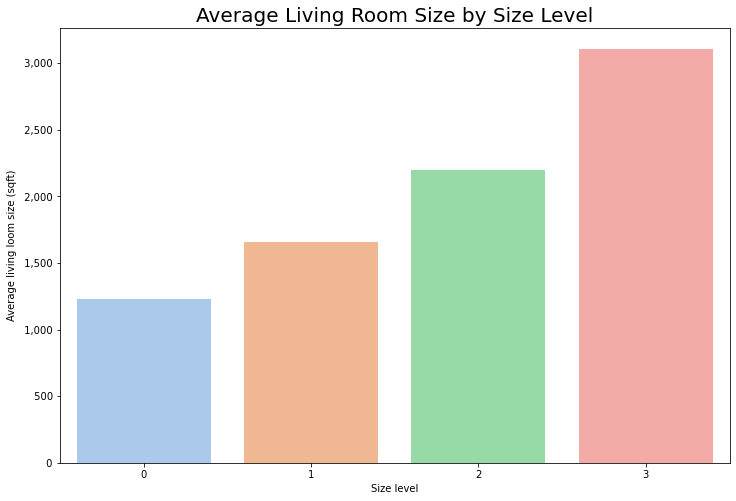

In [21]:
# Creates size classification
df['size'] = df['sqft_living15'].apply(lambda x:
                                       0 if x > 0 and x <= 1427 else
                                       1 if x > 1427 and x <= 1910 else
                                       2 if x > 1910 and x <= 2550 else 3)

# Sets figure size
plt.figure(figsize=(12, 8))

# Group data and takes mean size by size level
living_size_by_level = df[['sqft_living15', 'size']].groupby('size').mean().reset_index()

# Plots grapgh and sets titles
ax = sns.barplot(x='size', y='sqft_living15', data=living_size_by_level, palette='pastel')
ax.set_title('Average Living Room Size by Size Level', fontsize=20)
ax.set_ylabel('Average living loom size (sqft)')
ax.set_xlabel('Size level')

# Adjust y axis numbers formatter
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x: ,.0f}'))

### 3. Adicione as seguintes informações ao conjunto de dados original:
    1. Place ID: Identificação da localização
    2. OSM Type: Open Streeet Map Type
    3. Country: Nome do País
    4. Country Code: Código do país


In [22]:
print(f'Place ID: {response.raw["place_id"]}')
print(f'OSM type: {response.raw["osm_type"]}')

Place ID: 296045104
OSM type: way


In [23]:
# Create new columns
df['place_id'] = 'NA'
df['osm_type'] = 'NA'
# All addresses are from US, so have the same country
df['country'] = 'United States'
df['country_code'] = 'us' 

# Open API's request
geolocator = Nominatim(user_agent='geoapiExercises')

# Loop over lat & long and populate created columns with desired info
for i in range(0, len(df.head())):

    # Creates variable to concat lat and long and convert to string
    query = str(df['lat'][i]) + ',' + str(df['long'][i])

    # Request API's info using cooordinates
    response = geolocator.reverse(query)

    if 'place_id' in response.raw:
        df['place_id'][i] = response.raw['place_id']
        
    if 'osm_type' in response.raw:
        df['osm_type'][i] = response.raw['osm_type']

C:\Users\andre\AppData\Local\Temp/ipykernel_9760/2096664428.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\andre\AppData\Local\Temp/ipykernel_9760/2096664428.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [24]:
df.sample(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,city,state,is_waterfront,year,year_week,size,place_id,osm_type,country,country_code
485,8732131090,2015-04-28,"295,000.00",4,2.50,2160,7725,1.00,0,0,...,NA,Washington,no,2015,2015-17,2,NA,NA,United States,us
14724,2310040230,2014-05-20,"350,000.00",4,2.25,2220,6953,2.00,0,0,...,NA,Washington,no,2014,2014-20,2,NA,NA,United States,us
9664,2944010210,2015-02-18,"1,093,000.00",4,2.50,3930,21894,2.00,0,0,...,NA,Washington,no,2015,2015-07,3,NA,NA,United States,us
20600,1438000390,2014-08-04,"469,995.00",4,2.50,2350,3800,2.00,0,0,...,NA,Washington,no,2014,2014-31,3,NA,NA,United States,us
15978,1329300480,2014-10-23,"376,950.00",4,2.50,2643,5750,2.00,0,0,...,NA,Washington,no,2014,2014-42,2,NA,NA,United States,us
15404,4401200460,2014-10-20,"813,000.00",4,2.50,3430,7508,2.00,0,0,...,NA,Washington,no,2014,2014-42,3,NA,NA,United States,us
3583,1274500300,2014-06-23,"200,000.00",3,1.50,1090,9600,1.00,0,0,...,NA,Washington,no,2014,2014-25,0,NA,NA,United States,us
5098,1775930440,2014-06-23,"479,000.00",3,2.25,2110,11319,2.00,0,0,...,NA,Washington,no,2014,2014-25,1,NA,NA,United States,us
5992,2781270440,2014-05-19,"241,000.00",2,2.00,1470,3128,2.00,0,0,...,NA,Washington,no,2014,2014-20,0,NA,NA,United States,us
10286,1022059032,2014-08-12,"401,500.00",4,2.50,3140,94525,2.00,0,0,...,NA,Washington,no,2014,2014-32,1,NA,NA,United States,us


### 4. Adicione os seguintes filtros no mapa:
    1. Tamanho mínimo da área da sala de estar
    2. Número de banheiros
    3. Valor máximo do preço
    4. Tamanho máximo da área do porão
    5. Filtro das condições do imóvel
    6. Filtro por ano de construção

In [25]:
# Creating interactive buttons buttons

# 1. Tamanho mínimo da área da sala de estar
living_room = widgets.IntSlider(value=6625,
                                min=290,
                                max=13540,
                                description='Living Room Area',
                                disabled=False,
                                continuous_update=False,
                                readout=True,
                                style={'description_width': 'initial'})


# 2. Número de banheiros
bathrooms = widgets.Dropdown(options=sorted(df['bathrooms'].unique()),
                             value=4,
                             description='Bathrooms')

# 3. Valor máximo do preço
price_limit = widgets.IntSlider(value=3812500.0,
                                min=75000.00,
                                max=7700000.00,
                                description='Price',
                                disabled=False,
                                continuous_update=False,
                                readout=True,
                                step=1
                                )

# 4. Tamanho máximo da área do porão
basement = widgets.IntSlider(value=2410,
                             min=0,
                             max=4820,
                             description='Basement Area',
                             disabled=False,
                             continuous_update=False,
                             readout=True,
                             style={'description_width': 'initial'}
                             )


# 5. Filtro das condições do imóvel
property_level = widgets.ToggleButtons(options=[0, 1, 2, 3],
                                       description='Property Level',
                                       disabled=False,
                                       style={'description_width': 'initial'})

In [26]:
# Function to plot map and input filters

def update_map(data, filter1, filter3, filter4, filter2, filter5):
    
    # Defining filter parameters
    par1 = data['sqft_living15'] <= filter1
    par2 = data['bathrooms'] == filter2
    par3 = data['price'] <= filter3
    par4 = data['sqft_basement'] <= filter4
    par5 = data['level'] == filter5
    
    # Inserts the filters on the data
    properties = data[par1 & par2 & par3 & par4 & par5][['id', 'lat', 'long', 'price', 'level']]
    
    # Plots map
    fig = px.scatter_mapbox(properties,
                            lat='lat',
                            lon='long',
                            hover_name='id',
                            color='level',
                            size='price',
                            color_continuous_scale=px.colors.sequential.Inferno,
                            zoom=8,
                            size_max=15
                            )
    
    # Updates some map's properties
    fig.update_layout(mapbox_style='open-street-map')
    fig.update_layout(height=500, margin={'r':0, 't':0, 'l':0, 'b':0})
    fig.show()

In [27]:
# Applying interactive function to input filters
widgets.interactive(update_map, 
                    data=fixed(df), 
                    filter1=living_room,
                    filter2=bathrooms,
                    filter3=price_limit,
                    filter4=basement,
                    filter5=property_level
                    )

interactive(children=(IntSlider(value=6625, continuous_update=False, description='Living Room Area', max=13540…

### 5. Adicione os seguintes filtros no dashboard:
    1. Filtro por data disponível pra compra
    2. Filtro por ano de renovação
    3. Filtro se possui vista para água ou não

Dash com as seguintes visualizações:
- Média de preço de compra por ano de construção
- Média de preço por caregoria de tamanho da sala
- Desvio padrão do preço por ano de construção

In [28]:
# Casting data dtypes to match the filters
df['year'] = df['year'].astype('int64')
df['yr_built'] = df['yr_built'].astype('int64')

# Checking data types
df[['yr_built', 'year', 'is_waterfront']].dtypes

yr_built          int64
year              int64
is_waterfront    object
dtype: object

In [29]:
# Creating interactive buttons

# Filter by yr_built
yr_built_dashboard = widgets.IntSlider(value=2015,
                                       min=1900,
                                       max=2015,
                                       description='Year of Construction',
                                       disabled=False,
                                       continuous_update=False,
                                       readout=True,
                                       style={'description_width': 'initial'})

# Filter by construction availability
availability_dashboard = widgets.Dropdown(options=[2014, 2015],
                                          value=2014,
                                          description='Available for Sale Year',
                                          disabled=False,
                                          style={'description_width': 'initial'})

# Water view filter
waterview_dashboard = widgets.Dropdown(options=['no', 'yes'],
                                       value='no',
                                       description='Water View',
                                       disabled=False,
                                       style={'description_width': 'initial'})

In [30]:
def update_dashboard(data, filter1, filter2, filter3):
    
    # Setting filter parameters within the dataframe
    param1 = data['yr_built'] <= filter1
    param2 = data['year'] == filter2
    param3 = data['is_waterfront'] == filter3

    # Add the filters to the dataframe
#     data = data[param1 & param2 & param3]
    data = data[param1 & param2 & param3]

    # Sets figure size
    fig = plt.figure(figsize=(20, 12))

    # Creates dashboard template
    specs = gridspec.GridSpec(nrows=2, ncols=2, figure=fig)
    
    # Sets dashboard layout 
    ax1 = fig.add_subplot(specs[0, :])  # 1st row - 1st column
    ax2 = fig.add_subplot(specs[1, 0])  # 2nd row - 1st column
    ax3 = fig.add_subplot(specs[1, 1])  # 2nd row - 2nd column
    
    # Plot1
    mean_price_by_year = data[['price', 'yr_built']].groupby('yr_built').mean().reset_index()
    g1 = sns.lineplot(data=mean_price_by_year, x='yr_built', y='price', ax=ax1)
    g1.set_title('Mean Price by Year')
    
    # Plot 2
    mean_price_by_size = data[['price', 'size']].groupby('size').mean().reset_index()
    g2 = sns.lineplot(data=mean_price_by_size, x='size', y='price', ax=ax2)
    g2.set_title('Mean price by living room size')
    
    # Plot 3
    std_dev_by_year = data[['price', 'yr_built']].groupby('yr_built').std().reset_index()
    g3 = sns.lineplot(data=std_dev_by_year, x='yr_built', y='price', ax=ax3)
    g3.set_title('Price standard deviation by year')

In [31]:
widgets.interactive(update_dashboard, 
                    data=fixed(df), 
                    filter1=yr_built_dashboard,
                    filter2=availability_dashboard,
                    filter3=waterview_dashboard)

interactive(children=(IntSlider(value=2015, continuous_update=False, description='Year of Construction', max=2…

### Another way to solve question 3 (with multi thread processing)

In [32]:
# Importing libraries to help create workers with Nominatim
import time
from multiprocessing import Pool

In [33]:
# Create the API door to request the information
geolocator = Nominatim(user_agent='geopyExercises')

# Create a query column with the coordinates (Since we're applying to more than one column, we need to inform the axis)
df['query'] = df[['lat', 'long']].apply(lambda x: str(x['lat']) +','+ str(x['long']), axis=1)
df1 = df[['id', 'query']].sample(10)
df1

,id,query
20516,2919700107,"47.6905,-122.364"
6293,3317010130,"47.2613,-122.302"
19644,1442880260,"47.4832,-121.774"
21016,291310180,"47.5344,-122.068"
6784,6819100345,"47.6465,-122.357"
17339,7852000010,"47.5382,-121.871"
10555,1522039105,"47.3979,-122.416"
9194,1796370150,"47.3719,-122.091"
4357,3364900375,"47.6731,-122.326"
5026,6205500280,"47.5866,-122.175"


Jupyter Notebook is sequential, so it is not able to run multi thread requests. So, we need to create the function in another place and import it as a module.

In [34]:
# # The funcition will receive x as parameter, being that x=row within iterrows()
# def get_data(x):
    
#     # Each item will create an index and a row, that is the content
#     index, row = x
    
#     # Interval between actions
#     time.sleep(1)
    
#     # Requesting on API and saving to a variable
#     response = geolocator.reverse(row['query'])
    
#     # Acessing the information and saving it to a variable
#     place_id = response.raw['place_id']
#     osm_type = response.raw['osm_type']
#     country = response.raw['address']['country']
#     country_code = response.raw['address']['country_code']
    
#     return place_id, osm_type, country, country_code

We created the function in a .py file, imported the file and called it as library.module (defs.get_data)

In [35]:
import defs

# Creating the number of workers, which each one one will perform a process
p = Pool(3)

# Creating the timer that will perform the process
start = time.process_time()

# Creating the necessary columns 
df1[['place_id', 'osm_type', 'contry', 'country_code']] = p.map(defs.get_data, df1.iterrows())
end = time.process_time()

print(f'Time Elapsed : {end - start}')

Time Elapsed : 0.015625


In [36]:
df1

,id,query,place_id,osm_type,contry,country_code
20516,2919700107,"47.6905,-122.364",157259355,way,United States,us
6293,3317010130,"47.2613,-122.302",232536468,way,United States,us
19644,1442880260,"47.4832,-121.774",296099377,way,United States,us
21016,291310180,"47.5344,-122.068",296123316,way,United States,us
6784,6819100345,"47.6465,-122.357",157192512,way,United States,us
17339,7852000010,"47.5382,-121.871",96328506,way,United States,us
10555,1522039105,"47.3979,-122.416",98214046,way,United States,us
9194,1796370150,"47.3719,-122.091",232478015,way,United States,us
4357,3364900375,"47.6731,-122.326",157073552,way,United States,us
5026,6205500280,"47.5866,-122.175",296003558,way,United States,us


# 4. REFACTORING CODE

In [14]:
### Libraries and Auxiliary Commands ###
import pandas as pd
import plotly.express as px
import ipywidgets as widgets
import seaborn as sns
from geopy.geocoders import Nominatim
from ipywidgets import fixed, interact, interact_manual, interactive
from matplotlib import gridspec
from matplotlib import pyplot as plt
from matplotlib import ticker

### Functions ###
def show_data_types(data):
    '''
    When called, show the types of data in the columns of a given DataFrame
    '''
    types = df.dtypes
    
    return types

def plot_map(data, lat, long, size, color):
    '''
    Plots a map using data of a given DataFrame
    Lat: Latitude column within DataFrame
    Long: Longitude column within DataFrame
    Size: Which feature will define the size of each point
    Color: Which feature will define the color of each point
    '''
    
    columns = [lat, long, size, color]
    
    properties = df[columns]

    # Plot map
    fig = px.scatter_mapbox(
                            lat = properties.iloc[:, 0],
                            lon = properties.iloc[:, 1],
                            size = properties.iloc[:, 2],
                            color = properties.iloc[:, 3],
                            zoom = 10)

    fig.update_layout(mapbox_style='open-street-map', title = 'Available Properties in Seattle-WA')
    fig.update_layout(height=600, margin={'r':0, 't':0, 'l':0, 'b':0})
    fig.show()
    
    return None

def update_map(data, waterfront, limit):

    properties = data[(data['price'] <= limit) & (data['waterfront'] == waterfront)]
    [['id', 'lat', 'long', 'price', 'level']]

    fig = px.scatter_mapbox(properties,
                            lat = 'lat',
                            lon = 'long',
                            color = 'level',
                            size = 'price',
                            size_max=15,
                            color_continuous_scale=px.colors.cyclical.IceFire,
                            zoom = 10)

    fig.update_layout(mapbox_style='open-street-map')
    fig.update_layout(height=600, margin={'r':0, 't':0, 'l':0, 'b':0})
    fig.show()
    
    return None

def update_dashboard(data, limit):

    # Filter date
    data = data[data['date'] >= limit]

    fig = plt.figure(figsize=(24, 12))
    specs = gridspec.GridSpec(nrows=2, ncols=2, figure=fig)

    ax1 = fig.add_subplot(specs[0,:]) # First row
    ax2 = fig.add_subplot(specs[1,0]) # Second row - First colum
    ax3 = fig.add_subplot(specs[1,1]) # Second row - Second column

    by_year = data[['price', 'year']].groupby('year').sum().reset_index()
    ax1.bar(by_year['year'], by_year['price'])
    ax1.set_title('Sum of Prices by Year')

    by_day = data[['price', 'date']].groupby('date').mean().reset_index()
    ax2.plot(by_day['date'], by_day['price'])
    ax2.set_title('Average Price by Day')

    by_week = data[['price', 'year_week']].groupby('year_week').mean().reset_index()
    ax3.bar(by_week['year_week'], by_week['price'])
    ax3.set_title('Average Price by Week')

    plt.xticks(rotation=60)  

    return ax1, ax2, ax3

### Data Collecting ###
def get_data(path):
    '''
    Creates a Pandas DataFrame with a csv file, given its path as parameter
    '''
    data = pd.read_csv(path)
    
    return data 

### Data Prepraring ###
def data_preparation(data):
    '''
    Prepare data with several manipulations, in order to solve the questions asked by CEO
    '''
    
    # The level is defined by a lambda function, given the range of pprice of it
    data['level'] = data['price'].apply(lambda x: 0 if (x < 321950) else
                                    1 if (x >= 321950) & (x < 450000) else
                                    2 if (x >= 450000) & (x < 645000) else 3)

    
    # Create empty rows that will receive the address info
    data['road'] = 'NA'
    data['house_number'] = 'NA'
    data['neighbourhood'] = 'NA'
    data['city'] = 'NA' 
    data['state'] = 'Washington' # State will always be Washington
    
    # Changes the value from 0/1 to no/yes
    data['waterfront'] = data['waterfront'].apply(lambda x: 'yes' if x == 1
                                             else 'no')
    
    # Change Date formats to create specific granularities with dates
    data['year'] = pd.to_datetime(data['date']).dt.strftime('%Y')
    data['date'] = pd.to_datetime(data['date']).dt.strftime('%Y-%m-%d')
    data['year_week'] = pd.to_datetime(data['date']).dt.strftime('%Y-%U')
    
    return data

### Answering CEO's Questions ### 
def question_one(data):
    
    #  Counts the values of each level
    one = data['level'].value_counts().reset_index()
    
    # Plots the chart and set a title
    ax1 = sns.barplot(x='index', y='level', data=one, palette='pastel')
    ax1.set_title('1. Count of Properties by Level');
    
    return ax1

def question_two(data):
    
    # Initializing API
    geolocator = Nominatim(user_agent='geoapiExercises')

    # Iterate over the dataframe range
    for i in range(0, len(data.head())):

        # Request address info from API using coordinates
        response = geolocator.reverse(str(data['lat'][i]) + ',' + str(data['long'][i]))

        # Populate date
        if 'road' in response.raw['address']:
            data.loc[i, 'road'] = response.raw['address']['road']

        if 'house_number' in response.raw['address']:
            data.loc[i, 'house_number'] = response.raw['address']['house_number']

        if 'neighbourhood' in response.raw['address']:
            data.loc[i, 'neighbourhood'] = response.raw['address']['neighbourhood']

        if 'city' in response.raw['address']:
            data.loc[i, 'city'] = response.raw['address']['city']

    return data.head()

def question_three(data):
    
    mapa = plot_map(data, 'lat', 'long', 'price', 'level')
    
    return mapa

def question_four(data):
    
    style = {'description_widht': 'initial'}

    # Interactive buttons
    price_limit = widgets.IntSlider(
        value=500000, 
        min=75000, 
        max=7700000, 
        step=1, 
        description='Maximum Price', 
        disable=False, 
        style=style)

    waterfront_bar = widgets.Dropdown(
        options=data['waterfront'].unique().tolist(),
        value='yes',
        description='Water View',
        disable=False)
    
    interactive_map = widgets.interactive(update_map, data=fixed(data), waterfront=waterfront_bar, limit=price_limit)
        
    return interactive_map
    
def question_five(data):

    # Widgets to control data
    date_limit = widgets.SelectionSlider(
                    options=data['date'].sort_values().drop_duplicates().to_list(),
                    value='2014-12-01',
                    description='Availability',
                    continuous_update=False,
                    orientation='horizontal',
                    readout=True)
    
    dashboard = widgets.interactive(update_dashboard, data=fixed(data), limit=date_limit)

    return dashboard
    

    # Extract
    df_raw = get_data(r'C:\Users\andre\repos\python-zero-ao-ds\datasets\kc_house_data.csv')

    # Transform 
    df = data_preparation(df_raw)

### Extraction

In [ ]:
df_raw = get_data(r'C:\Users\andre\repos\python-zero-ao-ds\datasets\kc_house_data.csv')

### Transformations

In [ ]:
df = data_preparation(df_raw)

### Loading

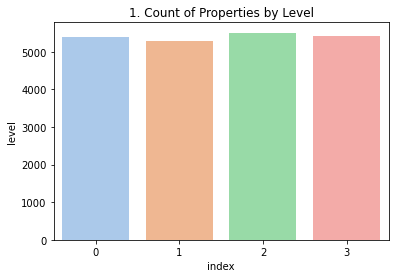

In [9]:
# 1. Amount of properties by level
question_one(df)
plt.show()

In [10]:
# 2. Get address info
question_two(df)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_living15,sqft_lot15,level,road,house_number,neighbourhood,city,state,year,year_week
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,no,0,...,1340,5650,0,61st Avenue South,10012,Rainier Beach,Seattle,Washington,2014,2014-41
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,no,0,...,1690,7639,2,Northeast 127th Street,837,NA,Seattle,Washington,2014,2014-49
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,no,0,...,2720,8062,0,81st Avenue Northeast,15109,NA,Kenmore,Washington,2015,2015-08
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,no,0,...,1360,5000,2,Fauntleroy Way Southwest,9236,Fauntleroy,Seattle,Washington,2014,2014-49
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,no,0,...,1800,7503,2,221st Avenue Northeast,923,NA,Sammamish,Washington,2015,2015-07


In [11]:
# 3. Map with dot color by level and dot size by price
question_three(df)

In [15]:
question_four(df)

interactive(children=(Dropdown(description='Water View', index=1, options=('no', 'yes'), value='yes'), IntSlid…

In [13]:
# 5. Interaction with dashboard
question_five(df)

interactive(children=(SelectionSlider(continuous_update=False, description='Availability', index=212, options=…